In [1]:
from google.colab import drive
drive.mount('/content/drive')

# 폰트 설치
import os
if not os.path.exists('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'):
    !sudo apt-get install -y fonts-nanum
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf

!pip install transformers scikit-learn seaborn matplotlib tabulate

import os
import random
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)
print(">>> 환경 설정 완료 & Random Seed set to 42")

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,302 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database

In [2]:
import torch
import torch.nn as nn
from transformers import AutoModel

class MultiHeadModel(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.rel_classifier = nn.Linear(768, 2)
        self.imp_classifier = nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)

        if isinstance(outputs, tuple):
            last_hidden_state = outputs[0]
        else:
            last_hidden_state = outputs.last_hidden_state

        pooled_output = last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        return self.rel_classifier(pooled_output), self.imp_classifier(pooled_output)

In [3]:
# 경로 및 장치 설정
BASE_PATH = "/content/drive/MyDrive/assignment5"
DATA_PATH = os.path.join(BASE_PATH, "data")
MODEL_PATH = os.path.join(BASE_PATH, "saved_model_v5") # V5 모델 사용
TEST_FILE = os.path.join(DATA_PATH, "test.csv")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 데이터 로드
if os.path.exists(TEST_FILE):
    test_df = pd.read_csv(TEST_FILE)
    test_df['text'] = test_df['title'] + " " + test_df['content'].fillna("")
    print(f">>> Test 데이터 로드 완료: {len(test_df)}건")
else:
    raise FileNotFoundError(f"파일 없음: {TEST_FILE}")

# 모델 및 토크나이저 로드
if os.path.exists(MODEL_PATH):
    print(f">>> 모델 로드 중... ({MODEL_PATH})")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    model = MultiHeadModel("klue/roberta-small")
    model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "pytorch_model.bin"), map_location=device))
    model.to(device)
    model.eval()
else:
    raise FileNotFoundError(f"모델 폴더 없음: {MODEL_PATH}")

# 예측 수행 함수
def predict_batch(texts, batch_size=32):
    all_rel = []
    all_imp = []

    print(f">>> 예측 시작 (총 {len(texts)}개)...")
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch, return_tensors="pt", truncation=True, max_length=512,
            padding=True
        ).to(device)

        with torch.no_grad():
            logits_rel, logits_imp = model(inputs['input_ids'], inputs['attention_mask'])
            all_rel.extend(torch.argmax(logits_rel, dim=1).cpu().tolist())
            all_imp.extend(torch.argmax(logits_imp, dim=1).cpu().tolist())

    return all_rel, all_imp

# 실제 예측 실행 및 저장
test_df['pred_rel'], test_df['pred_imp'] = predict_batch(test_df['text'].tolist())
print(">>> 예측 완료!")

Using device: cuda
>>> Test 데이터 로드 완료: 138건
>>> 모델 로드 중... (/content/drive/MyDrive/assignment5/saved_model_v5)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


>>> 예측 시작 (총 138개)...
>>> 예측 완료!



   [1] 전체 성능 평가 (Overall Performance)   
| 구분        |   Accuracy |   Macro Precision |   Macro Recall |   Macro F1 |
|:------------|-----------:|------------------:|---------------:|-----------:|
| 전체 관련도 |     0.8696 |            0.8682 |         0.8729 |     0.8689 |
| 전체 중요도 |     0.8261 |            0.7843 |         0.7878 |     0.7818 |
| 전체 통합   |     0.7536 |            0.7374 |         0.7468 |     0.7387 |

>>> 전체 데이터 Confusion Matrix


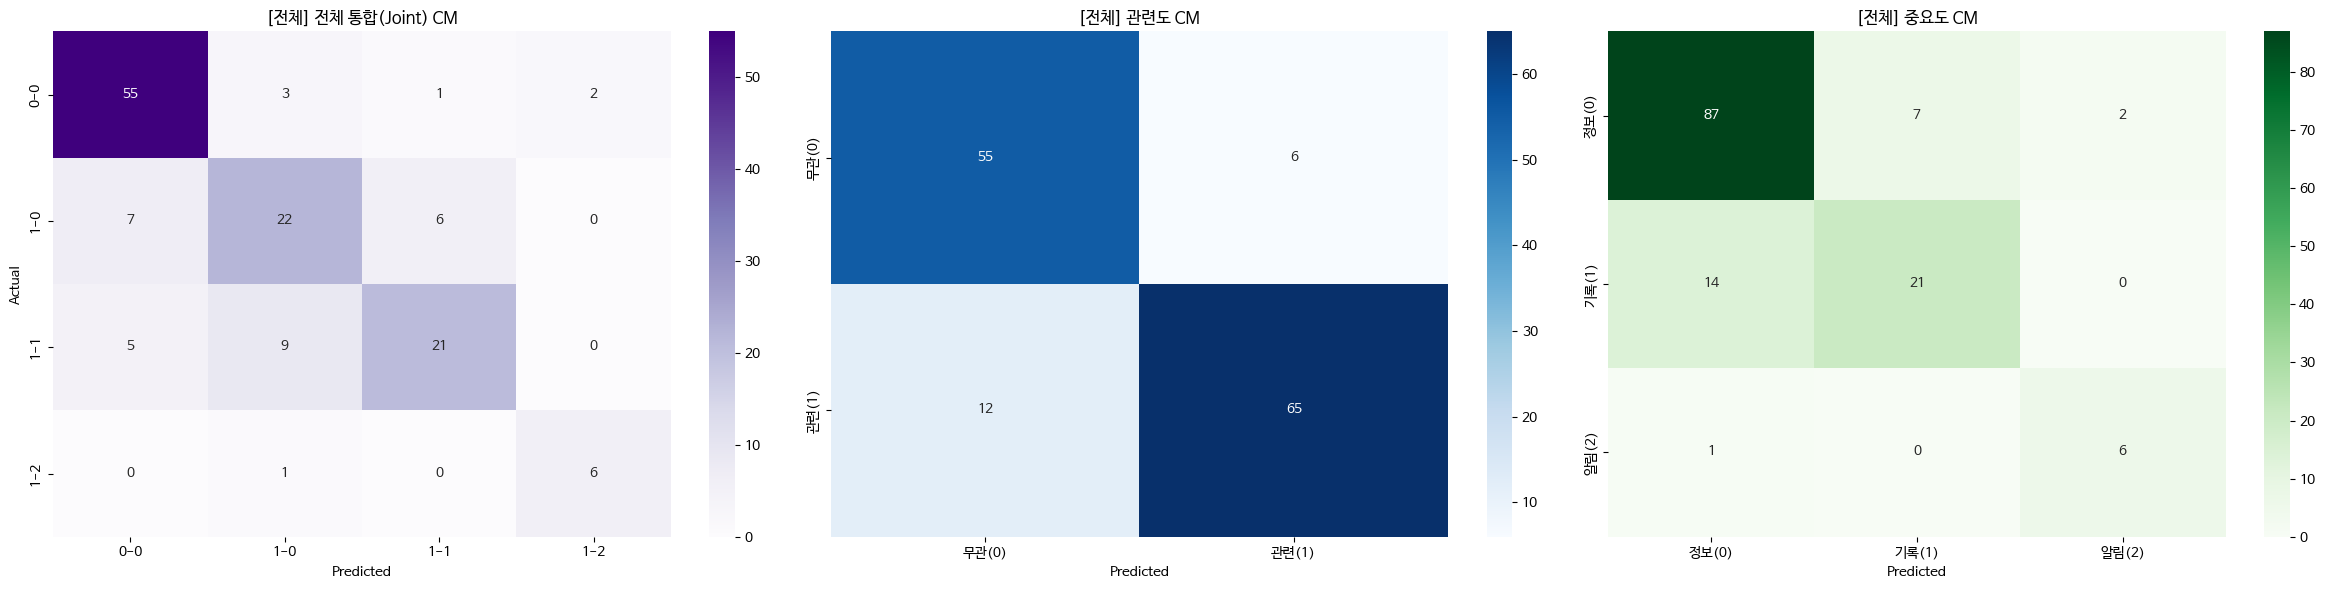


   [2] 카테고리별 상세 분석 (Category-wise)   

>>> 카테고리: 공지(일반) (개수=44)


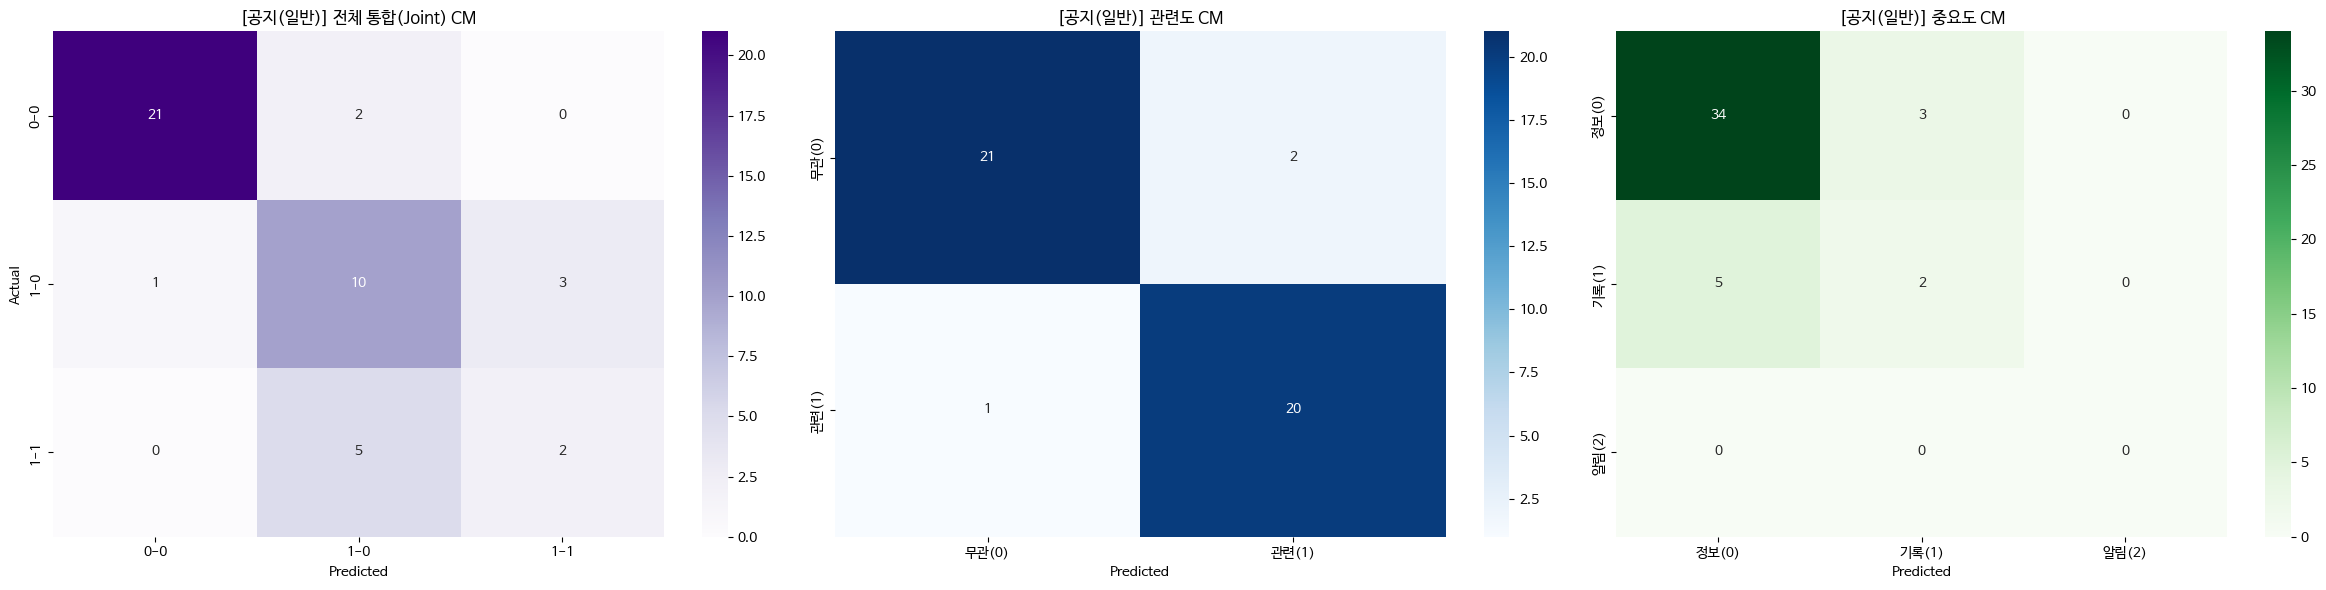


>>> 카테고리: 장학 (개수=31)


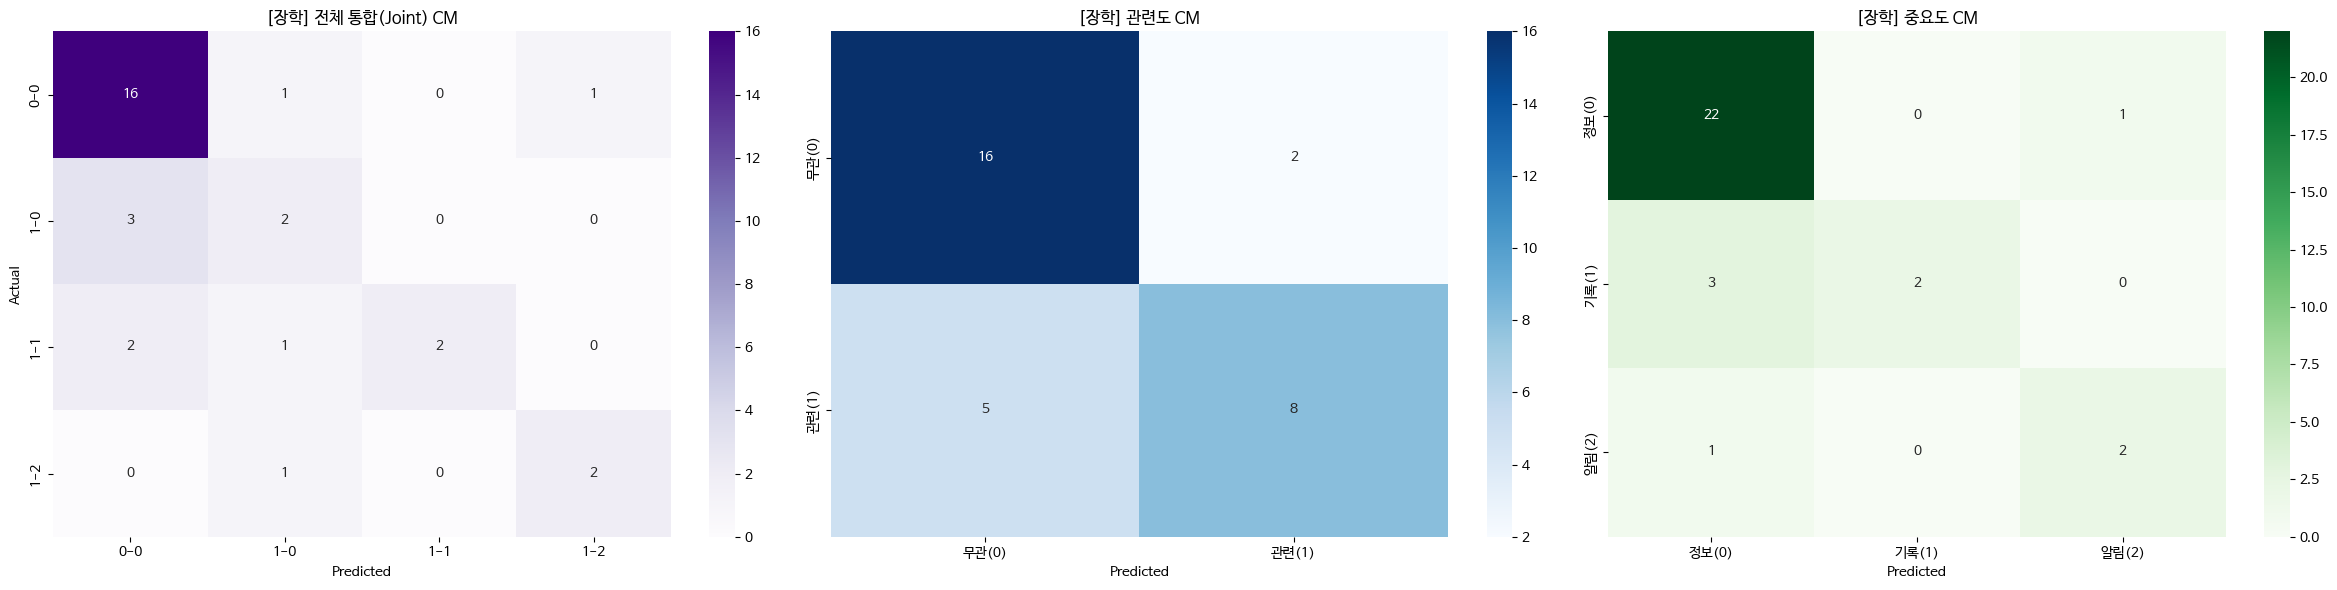


>>> 카테고리: IEL (개수=21)


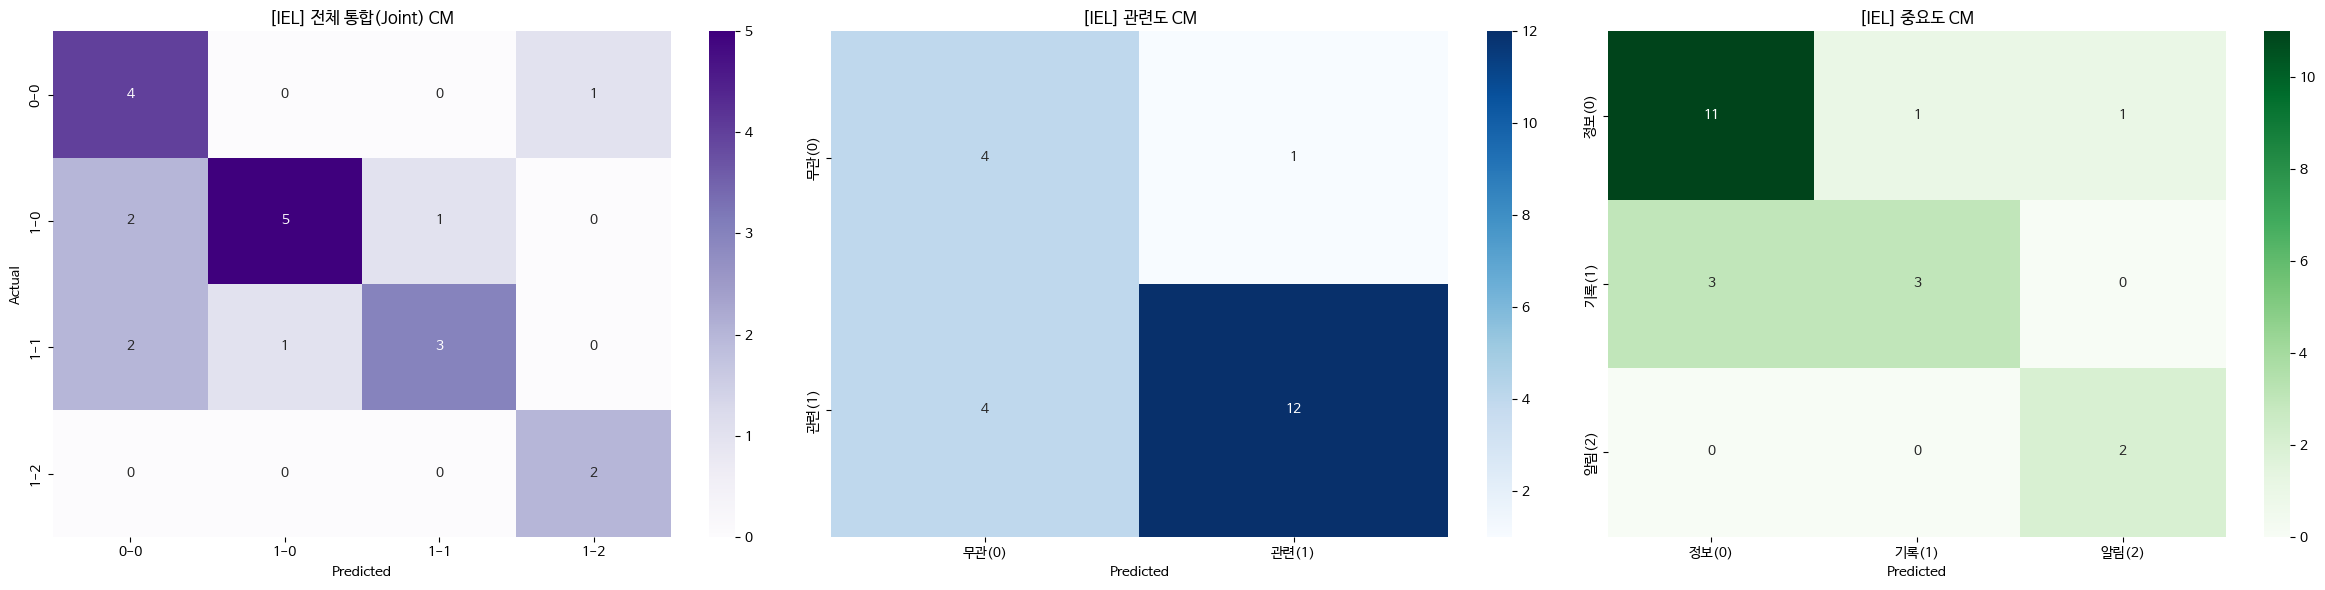


>>> 카테고리: LAI (개수=24)


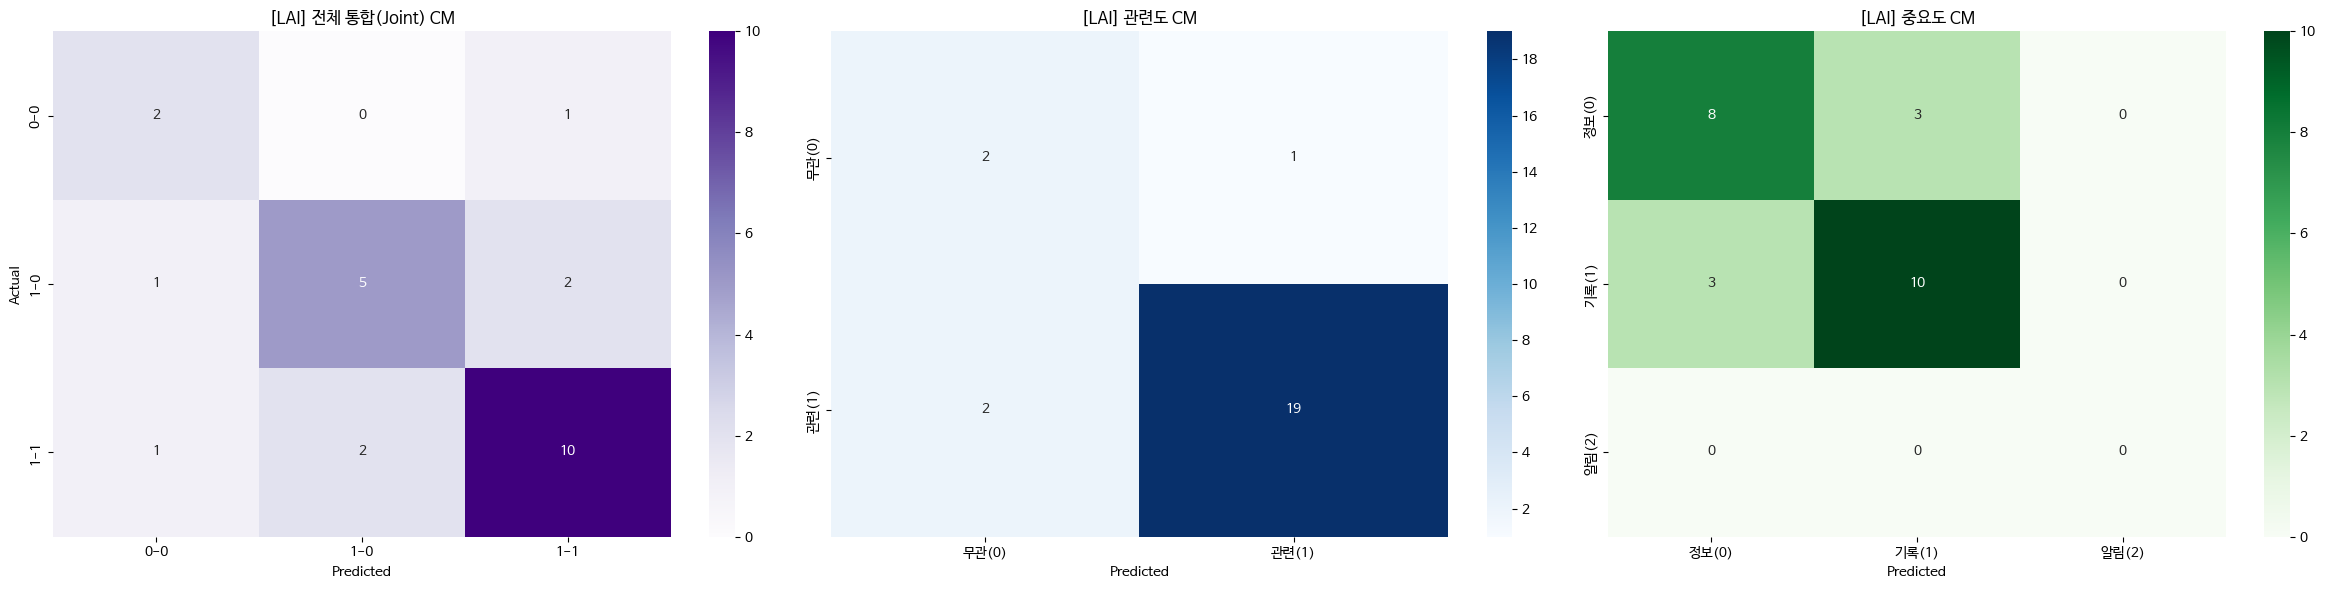


>>> 카테고리: 학사 (개수=18)


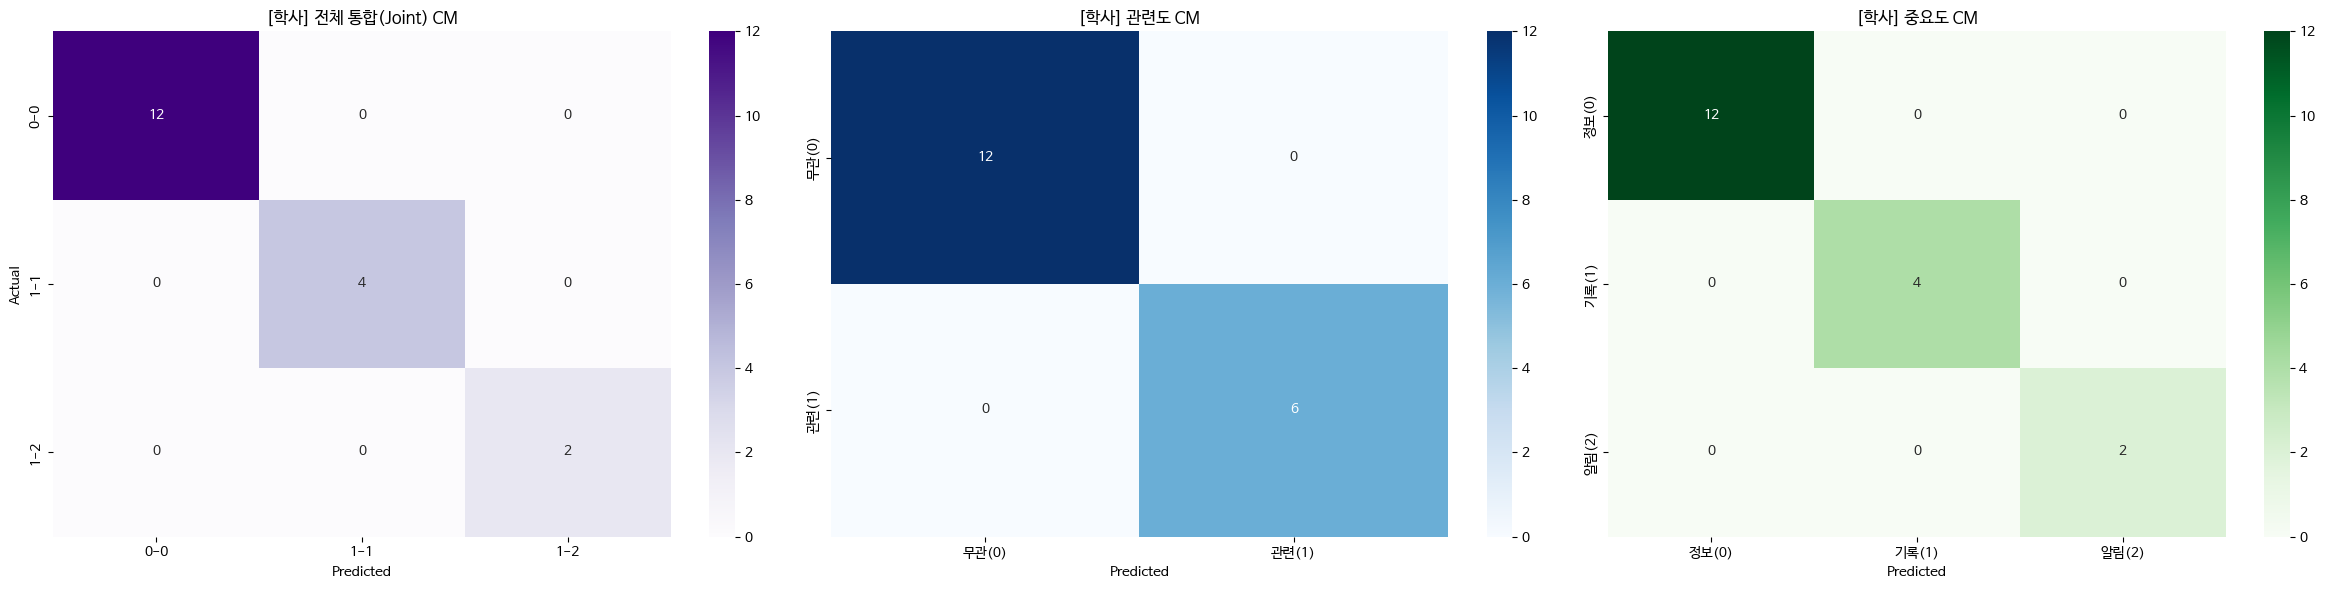


   [3] 카테고리별 성능 요약표 (Macro Average 기준)   
| 카테고리     |   개수 |   관련도_Acc |   관련도_Macro_P |   관련도_Macro_R |   관련도_Macro_F1 |   중요도_Acc |   중요도_Macro_P |   중요도_Macro_R |   중요도_Macro_F1 |   전체_Acc |   전체_Macro_P |   전체_Macro_R |   전체_Macro_F1 |
|:-------------|-------:|-------------:|-----------------:|-----------------:|------------------:|-------------:|-----------------:|-----------------:|------------------:|-----------:|---------------:|---------------:|----------------:|
| 공지(일반)   |     44 |       0.9318 |           0.9318 |           0.9327 |            0.9318 |       0.8182 |           0.6359 |           0.6023 |            0.614  |     0.75   |         0.6476 |         0.6377 |          0.6373 |
| 장학         |     31 |       0.7742 |           0.781  |           0.7521 |            0.7581 |       0.8387 |           0.8376 |           0.6744 |            0.712  |     0.7097 |         0.7071 |         0.5889 |          0.6147 |
| IEL          |     21 |       0.7619 |           0.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import os
import warnings

# 폰트 및 그래프 설정
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (24, 6)
plt.rcParams['axes.unicode_minus'] = False

# 폰트 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rc('font', family=font_name)
else:
    print("Warning: 한글 폰트가 설치되지 않았습니다. 그래프 한글이 깨질 수 있습니다.")

# 데이터 전처리: 통합 라벨(Joint Label) 생성
# 관련도와 중요도를 합쳐서 하나의 클래스로 정의
if 'label_joint' not in test_df.columns:
    test_df['label_joint'] = test_df['label_relevance'].astype(str) + "-" + test_df['label_importance'].astype(str)
if 'pred_joint' not in test_df.columns:
    test_df['pred_joint'] = test_df['pred_rel'].astype(str) + "-" + test_df['pred_imp'].astype(str)

# 함수 정의
def get_metrics(y_true, y_pred):
    """Accuracy, Macro P, R, F1 반환"""
    acc = accuracy_score(y_true, y_pred)
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    return acc, p, r, f

def plot_3_cm(df, title_prefix=""):
    """
    한 줄에 3개의 Confusion Matrix를 출력 (통합 -> 관련도 -> 중요도)
    """
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # (1) 통합 (Joint) CM
    joint_labels = sorted(list(set(df['label_joint'].unique()) | set(df['pred_joint'].unique())))
    cm_joint = confusion_matrix(df['label_joint'], df['pred_joint'], labels=joint_labels)
    sns.heatmap(cm_joint, annot=True, fmt='d', cmap='Purples', ax=axes[0],
                xticklabels=joint_labels, yticklabels=joint_labels)
    axes[0].set_title(f"{title_prefix} 전체 통합(Joint) CM")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # (2) 관련도 (Relevance) CM
    rel_labels = [0, 1]
    rel_names = ["무관(0)", "관련(1)"]
    cm_rel = confusion_matrix(df['label_relevance'], df['pred_rel'], labels=rel_labels)
    sns.heatmap(cm_rel, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                xticklabels=rel_names, yticklabels=rel_names)
    axes[1].set_title(f"{title_prefix} 관련도 CM")
    axes[1].set_xlabel("Predicted")

    # (3) 중요도 (Importance) CM
    imp_labels = [0, 1, 2]
    imp_names = ["정보(0)", "기록(1)", "알림(2)"]
    cm_imp = confusion_matrix(df['label_importance'], df['pred_imp'], labels=imp_labels)
    sns.heatmap(cm_imp, annot=True, fmt='d', cmap='Greens', ax=axes[2],
                xticklabels=imp_names, yticklabels=imp_names)
    axes[2].set_title(f"{title_prefix} 중요도 CM")
    axes[2].set_xlabel("Predicted")

    plt.tight_layout()
    plt.show()

# 전체 성능 평가
print("\n" + "="*80)
print("   [1] 전체 성능 평가 (Overall Performance)   ")
print("="*80)

# (1) 관련도 메트릭
r_acc, r_p, r_r, r_f = get_metrics(test_df['label_relevance'], test_df['pred_rel'])
# (2) 중요도 메트릭
i_acc, i_p, i_r, i_f = get_metrics(test_df['label_importance'], test_df['pred_imp'])
# (3) 통합(Joint) 메트릭
j_acc, j_p, j_r, j_f = get_metrics(test_df['label_joint'], test_df['pred_joint'])

overall_data = [
    {"구분": "전체 관련도", "Accuracy": r_acc, "Macro Precision": r_p, "Macro Recall": r_r, "Macro F1": r_f},
    {"구분": "전체 중요도", "Accuracy": i_acc, "Macro Precision": i_p, "Macro Recall": i_r, "Macro F1": i_f},
    {"구분": "전체 통합",   "Accuracy": j_acc, "Macro Precision": j_p, "Macro Recall": j_r, "Macro F1": j_f}
]

print(pd.DataFrame(overall_data).round(4).to_markdown(index=False))

# 전체 데이터 Confusion Matrix
print("\n>>> 전체 데이터 Confusion Matrix")
plot_3_cm(test_df, title_prefix="[전체]")

# 카테고리별 상세 평가
print("\n" + "="*80)
print("   [2] 카테고리별 상세 분석 (Category-wise)   ")
print("="*80)

target_order = ['공지(일반)', '장학', 'IEL', 'LAI', '학사']
categories = [cat for cat in target_order if cat in test_df['eval_category'].unique()]

summary_data = []

for cat in categories:
    sub = test_df[test_df['eval_category'] == cat]
    if len(sub) == 0: continue

    r_acc, r_p, r_r, r_f = get_metrics(sub['label_relevance'], sub['pred_rel'])
    i_acc, i_p, i_r, i_f = get_metrics(sub['label_importance'], sub['pred_imp'])
    j_acc, j_p, j_r, j_f = get_metrics(sub['label_joint'], sub['pred_joint'])

    summary_data.append({
        "카테고리": cat, "개수": len(sub),
        "관련도_Acc": r_acc, "관련도_Macro_P": r_p, "관련도_Macro_R": r_r, "관련도_Macro_F1": r_f,
        "중요도_Acc": i_acc, "중요도_Macro_P": i_p, "중요도_Macro_R": i_r, "중요도_Macro_F1": i_f,
        "전체_Acc": j_acc, "전체_Macro_P": j_p, "전체_Macro_R": j_r, "전체_Macro_F1": j_f
    })

    print(f"\n>>> 카테고리: {cat} (개수={len(sub)})")
    plot_3_cm(sub, title_prefix=f"[{cat}]")

# 최종 요약 표 출력
print("\n" + "="*80)
print("   [3] 카테고리별 성능 요약표 (Macro Average 기준)   ")
print("="*80)

total_r_acc, total_r_p, total_r_r, total_r_f = get_metrics(test_df['label_relevance'], test_df['pred_rel'])
total_i_acc, total_i_p, total_i_r, total_i_f = get_metrics(test_df['label_importance'], test_df['pred_imp'])
total_j_acc, total_j_p, total_j_r, total_j_f = get_metrics(test_df['label_joint'], test_df['pred_joint'])

target_order = ['공지(일반)', '장학', 'IEL', 'LAI', '학사']
categories = [cat for cat in target_order if cat in test_df['eval_category'].unique()]

summary_data = []

for cat in categories:
    sub = test_df[test_df['eval_category'] == cat]
    if len(sub) == 0: continue

    c_r_acc, c_r_p, c_r_r, c_r_f = get_metrics(sub['label_relevance'], sub['pred_rel'])
    c_i_acc, c_i_p, c_i_r, c_i_f = get_metrics(sub['label_importance'], sub['pred_imp'])
    c_j_acc, c_j_p, c_j_r, c_j_f = get_metrics(sub['label_joint'], sub['pred_joint'])

    summary_data.append({
        "카테고리": cat, "개수": len(sub),
        "관련도_Acc": c_r_acc, "관련도_Macro_P": c_r_p, "관련도_Macro_R": c_r_r, "관련도_Macro_F1": c_r_f,
        "중요도_Acc": c_i_acc, "중요도_Macro_P": c_i_p, "중요도_Macro_R": c_i_r, "중요도_Macro_F1": c_i_f,
        "전체_Acc": c_j_acc, "전체_Macro_P": c_j_p, "전체_Macro_R": c_j_r, "전체_Macro_F1": c_j_f
    })

summary_data.append({
    "카테고리": "전체 (Total)", "개수": len(test_df),
    "관련도_Acc": total_r_acc, "관련도_Macro_P": total_r_p, "관련도_Macro_R": total_r_r, "관련도_Macro_F1": total_r_f,
    "중요도_Acc": total_i_acc, "중요도_Macro_P": total_i_p, "중요도_Macro_R": total_i_r, "중요도_Macro_F1": total_i_f,
    "전체_Acc": total_j_acc, "전체_Macro_P": total_j_p, "전체_Macro_R": total_j_r, "전체_Macro_F1": total_j_f
})

summary_df = pd.DataFrame(summary_data)

cols = ["카테고리", "개수",
        "관련도_Acc", "관련도_Macro_P", "관련도_Macro_R", "관련도_Macro_F1",
        "중요도_Acc", "중요도_Macro_P", "중요도_Macro_R", "중요도_Macro_F1",
        "전체_Acc", "전체_Macro_P", "전체_Macro_R", "전체_Macro_F1"]

print(summary_df[cols].round(4).to_markdown(index=False))